In [1]:
import glob
import numpy as np
import pandas as pd 
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

print('xarray = ', xr.__version__)
print('matplotlib = ', matplotlib.__version__)

almost_zero=1.0e-6
clon=180

land_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", facecolor=cfeature.COLORS["land"]
)

def plot_decor(ax):
    ax.coastlines("10m")
    ax.set_extent([172,180,-42,-34])
    ax.add_feature(land_10m, zorder=-1)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
    
def compute_arrival_time(dain, vmin=0.001):
    if dain.dims[0] != 'time':
        print(dain.shape)
        print('bad shape. Shoud be time, lat, lon')
        raise
    nt = dain.sizes['time']
    daout = xr.where(dain > vmin, 1., 0)
    daout = daout.cumsum(dim='time')
    daout = daout.where(daout > 0)
    # Assuming hourly data
    for it in range(nt):
         daout.data[it,...] = it+2 - daout.isel(time=it).data
    return daout


xarray =  0.18.2
matplotlib =  3.4.1


# Set customizable global variables

In [2]:
density = 1300 # kg/m3 andesite for Tongariro
it = -1  # plots for last time instant in files (same as it=23)

savefigs = True
fig_args = dict(bbox_inches='tight', dpi=300)

# UNCOMMENT FOR OPERATIONAL CASE STUDY
file_lhs = '202107150000/input/lh_sample_intermediate_n30_1.csv'
data_pattern = '202107150000/output/*Tongariro*nc'
fileplot_prefix = 'plt_det_202107150000_Tongariro'

# UNCOMMENT FOR HISTORICAL CASE STUDY
# file_lhs = '201208061200/input/lh_sample_intermediate_n20_1.csv'
# data_pattern = '201208061200/output/*Tongariro*nc'
# fileplot_prefix = 'plt_det_201208061200_Tongariro'

# Read files

In [3]:
files = glob.glob(data_pattern)
files.sort()
print(len(files))

for x in files[:3]:
    print(x)

30
202107150000/output/21071500_Tongariro_sample1_gep01_idx000_20.0_0.01.nc
202107150000/output/21071500_Tongariro_sample1_gep02_idx001_10.0_0.01.nc
202107150000/output/21071500_Tongariro_sample1_gep03_idx002_6.5_0.01.nc


In [4]:
ds = xr.open_mfdataset(files, combine='nested', concat_dim=['idx'])
ds

<xarray.Dataset>
Dimensions:           (idx: 30, lat: 1401, lon: 1401, time: 24)
Coordinates:
  * lat               (lat) float32 -48.0 -47.99 -47.98 ... -34.02 -34.01 -34.0
  * lon               (lon) float32 166.0 166.0 166.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2021-07-15T01:00:00 ... 2021-07-16
Dimensions without coordinates: idx
Data variables:
    total_deposition  (idx, time, lat, lon) float32 dask.array<chunksize=(1, 24, 1401, 1401), meta=np.ndarray>
Attributes:
    title:                   HYSPLIT v5.0.1
    Conventions:             CF-1.5
    eruption_time:           2021-07-15T00:00:00
    accumulation_period_h:   24
    volcano:                 Tongariro_sample1_gep01_idx000
    src_lat:                 -39.130001068115234
    src_lon:                 175.64199829101562
    plume_height_amsl_km:    20.0
    eruption_duration_hhmm:  0100

In [5]:
vlon, vlat = ds.attrs['src_lon'], ds.attrs['src_lat']
vlon, vlat

(175.64199829101562, -39.130001068115234)

## Add arrival time

In [6]:
ds.chunks

Frozen(SortedKeysDict({'idx': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), 'time': (24,), 'lat': (1401,), 'lon': (1401,)}))

In [7]:
nidx = ds.sizes['idx']
ds['arrival_time'] = ds['total_deposition'].copy(deep=True)
ds['arrival_time'].attrs['long_name'] = 'arrival time'
ds['arrival_time'].attrs['units'] = 'hours'
for idx in range(nidx):
    da = compute_arrival_time(ds['total_deposition'].isel(idx=idx))
    ds['arrival_time'].data[idx,...] = da

In [8]:
ds.chunks

Frozen(SortedKeysDict({'idx': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), 'time': (24,), 'lat': (1401,), 'lon': (1401,)}))

# Read scenarios

In [9]:
scenarios = pd.read_csv(file_lhs)
scenarios = scenarios.rename({'MER [kg/s]': 'MER', 'Column height [km]': 'H', 'Duration [h]': 'D'}, axis=1)

scenarios['MER'] = scenarios['MER']/1.e6 # MegaTons

# total mass erupted
scenarios['ME'] = scenarios['MER'] * scenarios['D']

scenarios.head()

,MER,H,D,ME
0,15.108590,25.000000,1.746452,26.386433
1,0.165745,8.045815,0.115099,0.019077
2,0.132223,4.490041,0.150156,0.019854
3,0.077960,15.628282,1.492920,0.116388
4,2.079814,14.176977,9.888995,20.567265


In [10]:
# Print max_ash_depth for each scenario just to have an idea of the range
ds_slice = ds['total_deposition'].isel(time=-1)
max_ash_depth = []
for i in range(ds_slice.sizes['idx']):
    da = ds_slice.isel(idx=i)    
    #print(i, np.round(np.nanmin(da),0),np.nanmax(da))
    max_ash_depth += [np.nanmax(da)]
    

# Adding max ash depth computed above
scenarios['max_ash_depth'] = max_ash_depth
scenarios

,MER,H,D,ME,max_ash_depth
0,15.108590,25.000000,1.746452,26.386433,141.413620
1,0.165745,8.045815,0.115099,0.019077,0.373418
2,0.132223,4.490041,0.150156,0.019854,1.297342
3,0.077960,15.628282,1.492920,0.116388,0.959685
4,2.079814,14.176977,9.888995,20.567265,143.628632
5,12.599827,12.003933,0.759169,9.565401,105.850464
6,5.598855,3.801809,0.097642,0.546683,33.739647
7,0.434413,11.147633,7.011795,3.046017,31.918264
8,16.206950,17.502652,5.394195,87.423443,563.341187
9,6.217120,5.543683,0.894927,5.563866,177.946457


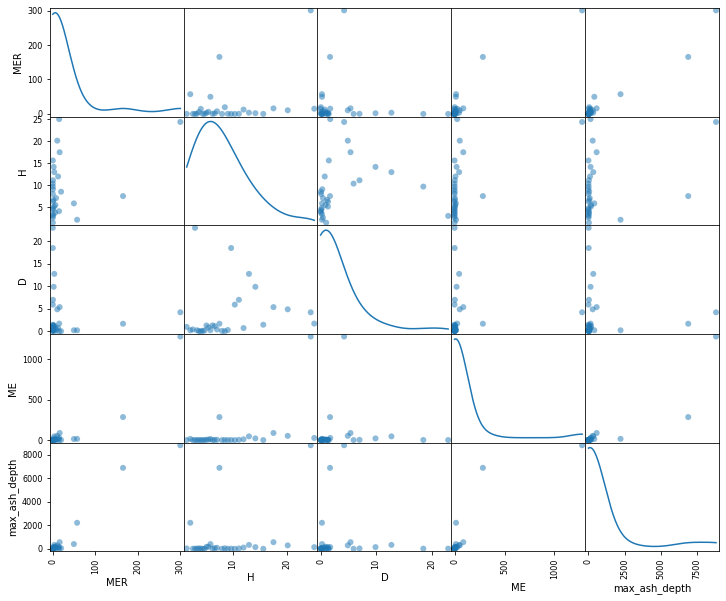

In [11]:
axs = pd.plotting.scatter_matrix(scenarios, diagonal='kde',figsize=(12,10), marker='o')

# Plots

## Define levels and colormaps

In [12]:
lev_max = 1e3
lev_min = 1e-3
lev_exp = np.arange(np.log10( lev_min), np.log10(lev_max).max() + 1)
print(lev_exp)
levs = np.power(10, lev_exp)
print(levs)


def mycolormap(cmap_name, n):
    cmap = plt.cm.get_cmap(cmap_name, len(levs)+1)
    colors = list(cmap(np.arange(len(levs)+1)))
    # replace first color with transparent
    colors[0][-1] = 0
    cmap2 = ListedColormap(colors)
    # set over-color to last color of list 
#     cmap2.set_over(colors[-1])
    return cmap2

cmap = plt.cm.get_cmap('hot_r', len(levs)+1)
cmap2 = mycolormap('hot_r', len(levs)+1)

[-3. -2. -1.  0.  1.  2.  3.]
[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]


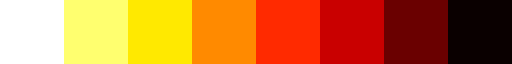

In [13]:
cmap

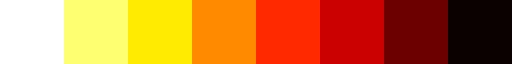

In [14]:
cmap2

## Plot ash depth + arrival time for each scenario

plt_det_202107150000_Tongariro_ashfall_arrival_idx000.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx001.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx002.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx003.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx004.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx005.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx006.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx007.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx008.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx009.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx010.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx011.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx012.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx013.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx014.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx015.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx016.png
plt_det_202107

<ipython-input-15-3e881f23d804>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=(8,6), subplot_kw={"projection": ccrs.PlateCarree(clon)})


plt_det_202107150000_Tongariro_ashfall_arrival_idx020.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx021.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx022.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx023.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx024.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx025.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx026.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx027.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx028.png
plt_det_202107150000_Tongariro_ashfall_arrival_idx029.png


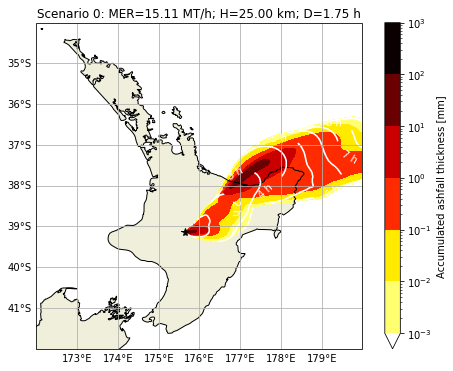

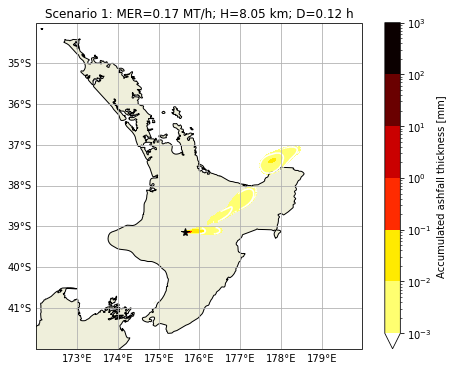

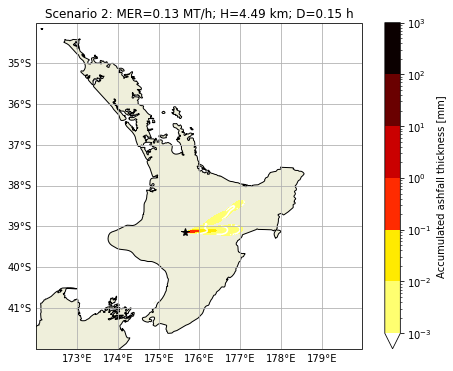

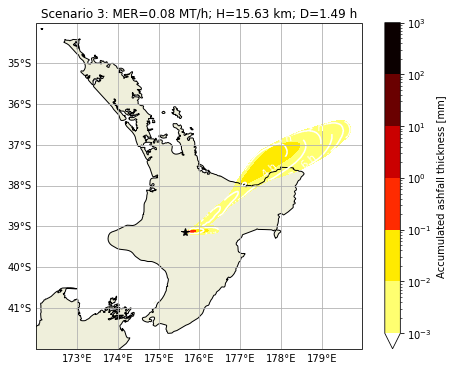

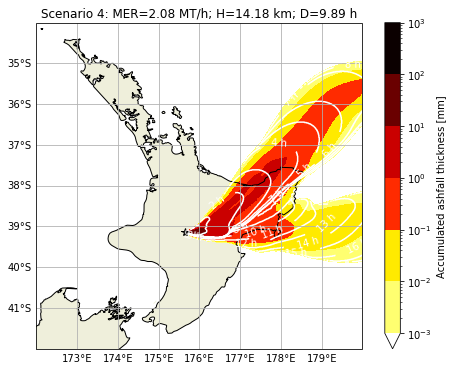

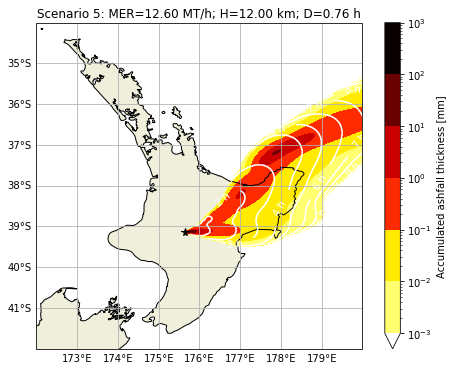

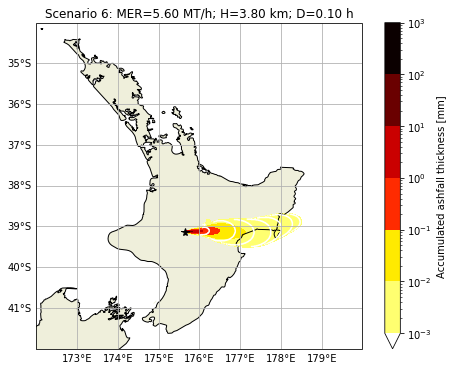

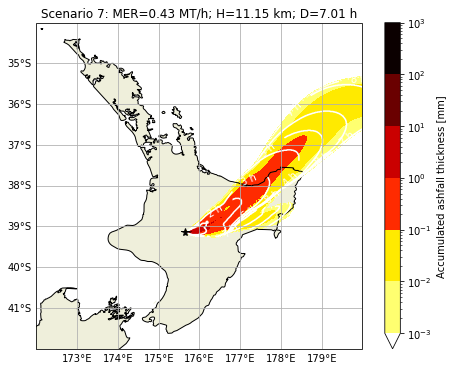

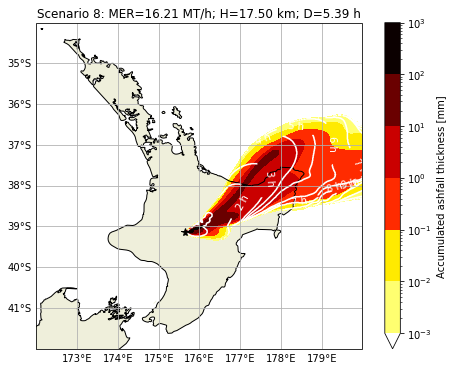

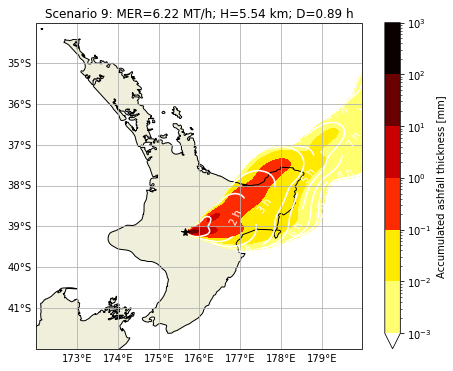

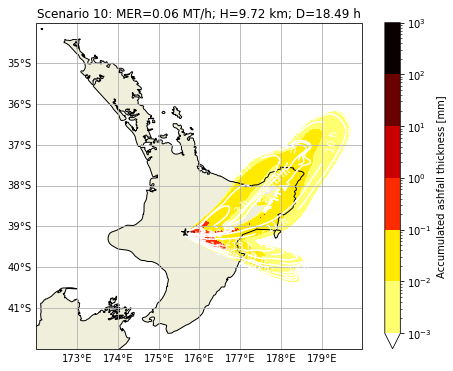

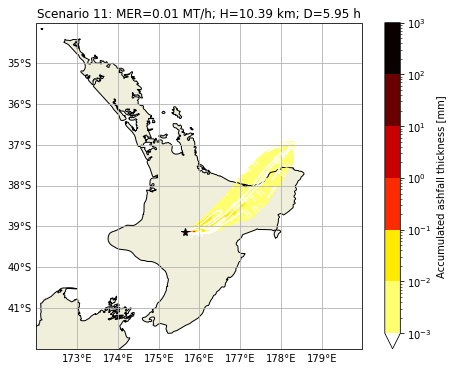

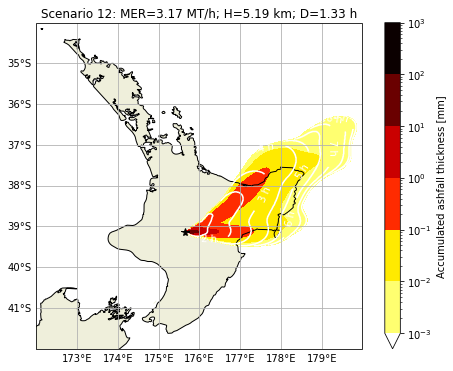

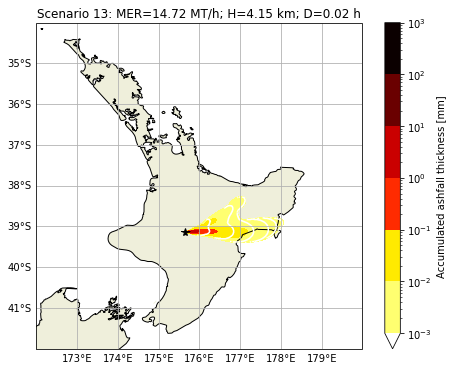

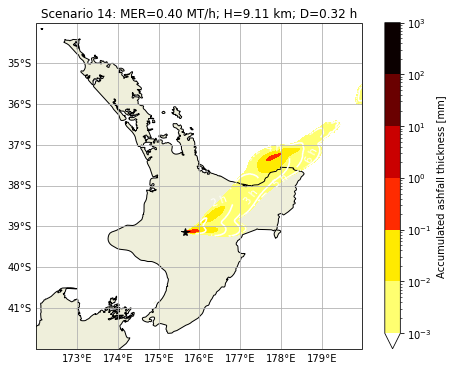

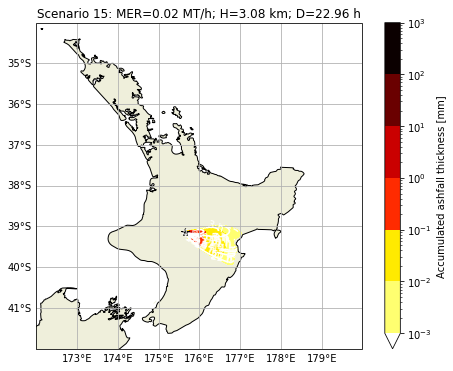

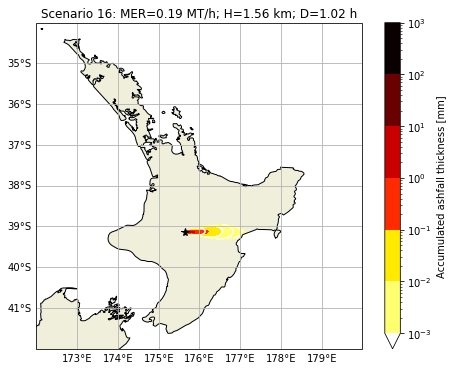

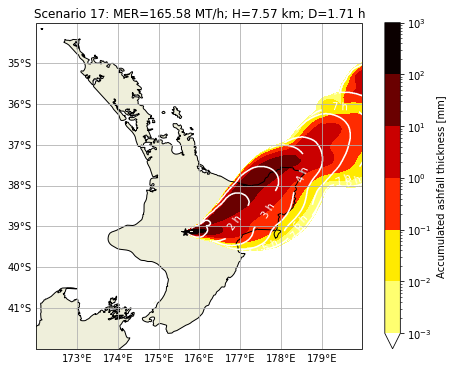

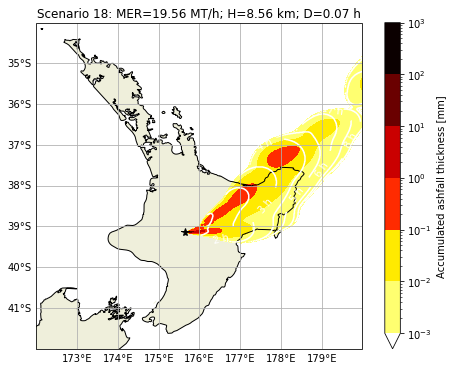

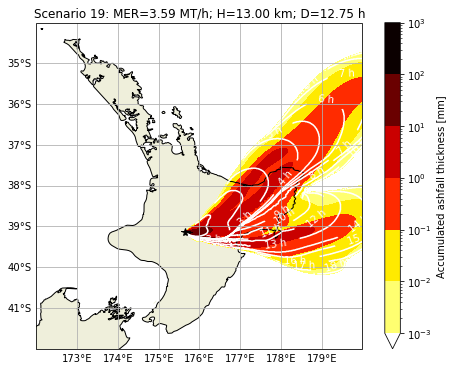

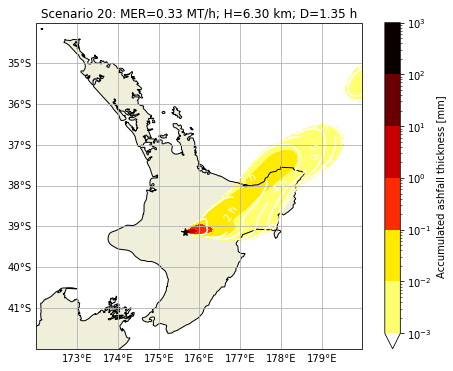

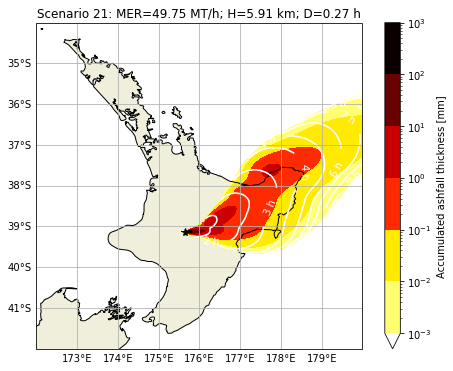

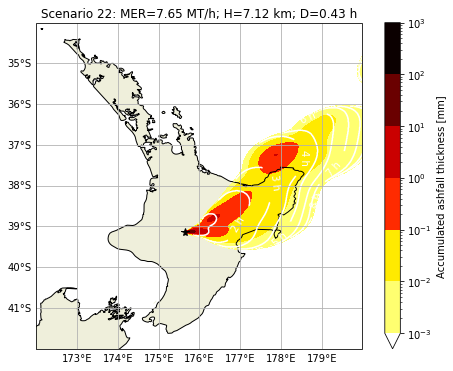

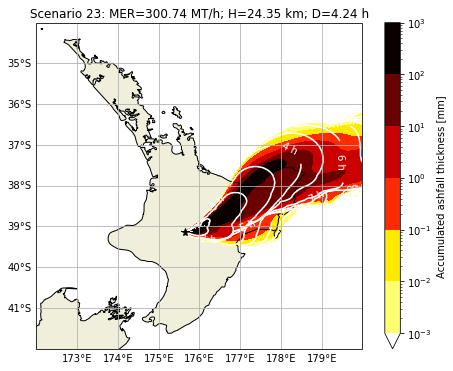

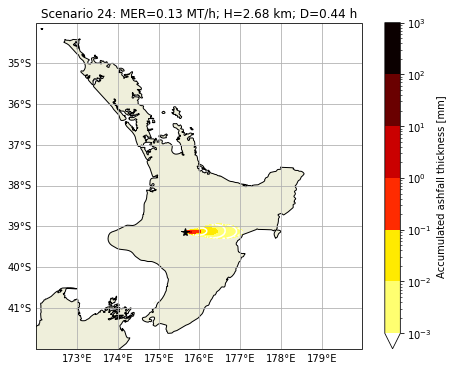

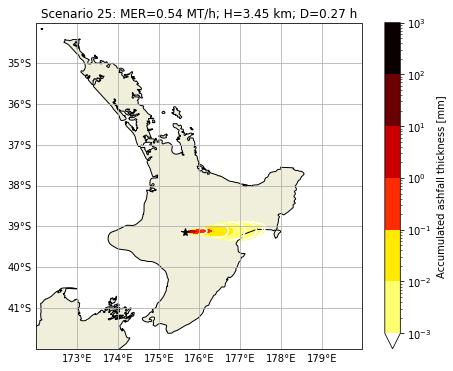

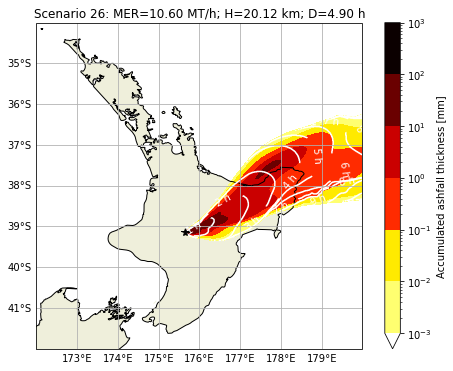

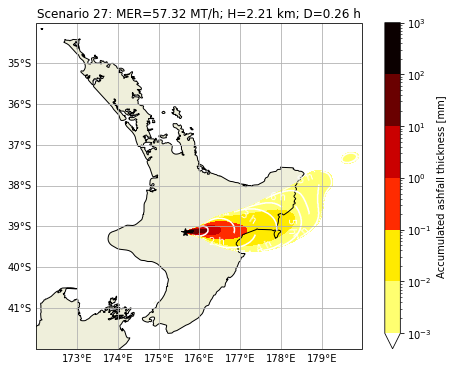

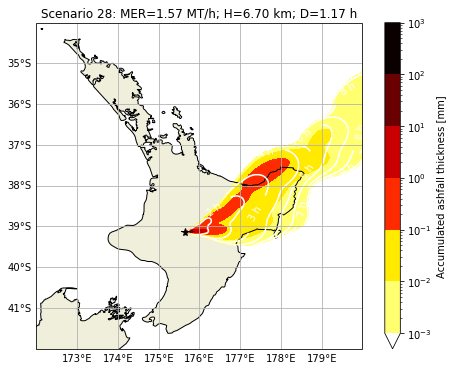

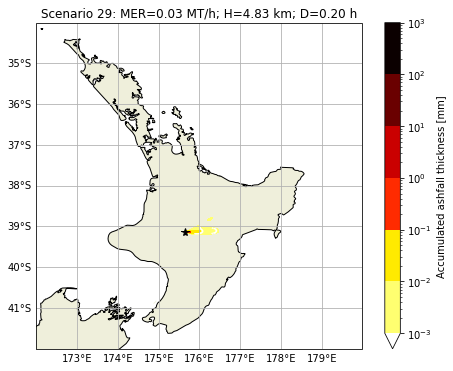

In [15]:
for idx in range(nidx):
    scenario = scenarios.iloc[idx]
    da = ds['total_deposition'].isel(idx=idx, time=it)
    da_arrival = ds['arrival_time'].isel(idx=idx, time=it)
    levels_arrival = np.arange(24)
    
    fig, ax = plt.subplots(1,1, figsize=(8,6), subplot_kw={"projection": ccrs.PlateCarree(clon)})
    p1 = da.plot.contourf(ax=ax, levels=levs, cmap=cmap2, norm=LogNorm(vmin=levs[0], vmax=levs[-1]),
        extend='min',
        transform=ccrs.PlateCarree(),
        cbar_kwargs={'label': 'Accumulated ashfall thickness [mm]'},
    )

    # contours after zooming..
    try:
        cs = da_arrival.plot.contour(ax=ax, levels=levels_arrival, colors='white',
            transform=ccrs.PlateCarree(),
        )
        plt.clabel(cs, levels=levels_arrival, fmt='%0d h') 
    except ValueError as exc:
        print(exc)
        print('Skipping...')
        
    ax.plot(vlon,vlat, transform=ccrs.PlateCarree(), marker='*', ms=8, color='k')
    plot_decor(ax)
    txtstr = 'Scenario {}: MER={MER:.2f} MT/h; H={H:.2f} km; D={D:.2f} h'.format(idx, **scenario)
    ax.set_title(txtstr)
    
    fileplot = fileplot_prefix + '_ashfall_arrival_idx{:03d}.png'.format(idx)
    print(fileplot)
    fig.savefig(fileplot, **fig_args)
    #plt.close()
    

## Plot ash depth for each scenario (for paper)

plt_det_202107150000_Tongariro_ashfall_idx000.png
plt_det_202107150000_Tongariro_ashfall_idx001.png
plt_det_202107150000_Tongariro_ashfall_idx002.png
plt_det_202107150000_Tongariro_ashfall_idx003.png
plt_det_202107150000_Tongariro_ashfall_idx004.png
plt_det_202107150000_Tongariro_ashfall_idx005.png
plt_det_202107150000_Tongariro_ashfall_idx006.png
plt_det_202107150000_Tongariro_ashfall_idx007.png
plt_det_202107150000_Tongariro_ashfall_idx008.png
plt_det_202107150000_Tongariro_ashfall_idx009.png
plt_det_202107150000_Tongariro_ashfall_idx010.png
plt_det_202107150000_Tongariro_ashfall_idx011.png
plt_det_202107150000_Tongariro_ashfall_idx012.png
plt_det_202107150000_Tongariro_ashfall_idx013.png
plt_det_202107150000_Tongariro_ashfall_idx014.png
plt_det_202107150000_Tongariro_ashfall_idx015.png
plt_det_202107150000_Tongariro_ashfall_idx016.png
plt_det_202107150000_Tongariro_ashfall_idx017.png
plt_det_202107150000_Tongariro_ashfall_idx018.png
plt_det_202107150000_Tongariro_ashfall_idx019.png


<ipython-input-16-b9273f99c339>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=(8,6), subplot_kw={"projection": ccrs.PlateCarree(clon)})


plt_det_202107150000_Tongariro_ashfall_idx020.png
plt_det_202107150000_Tongariro_ashfall_idx021.png
plt_det_202107150000_Tongariro_ashfall_idx022.png
plt_det_202107150000_Tongariro_ashfall_idx023.png
plt_det_202107150000_Tongariro_ashfall_idx024.png
plt_det_202107150000_Tongariro_ashfall_idx025.png
plt_det_202107150000_Tongariro_ashfall_idx026.png
plt_det_202107150000_Tongariro_ashfall_idx027.png
plt_det_202107150000_Tongariro_ashfall_idx028.png
plt_det_202107150000_Tongariro_ashfall_idx029.png


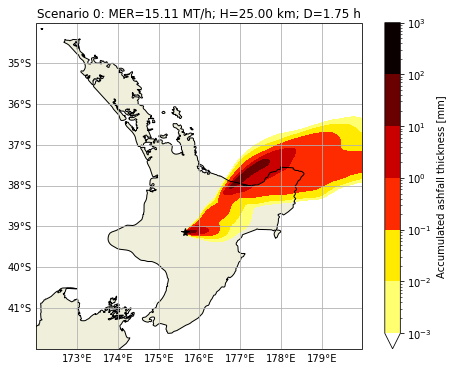

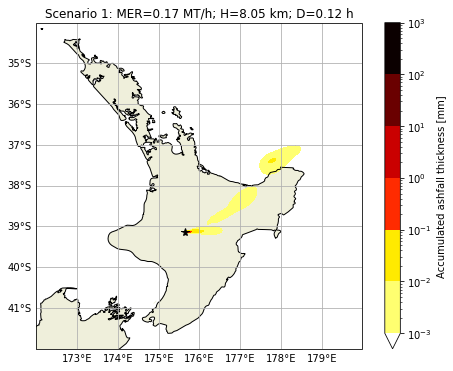

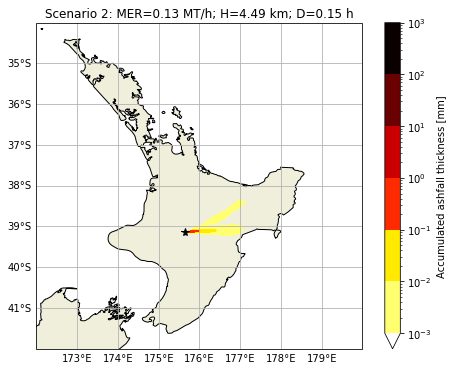

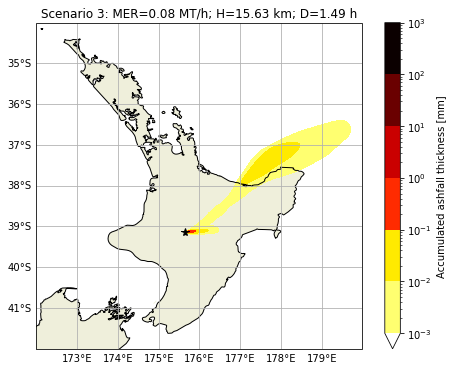

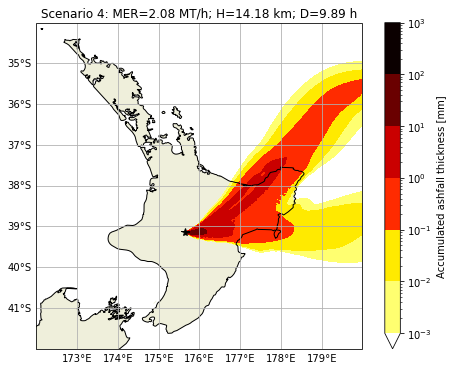

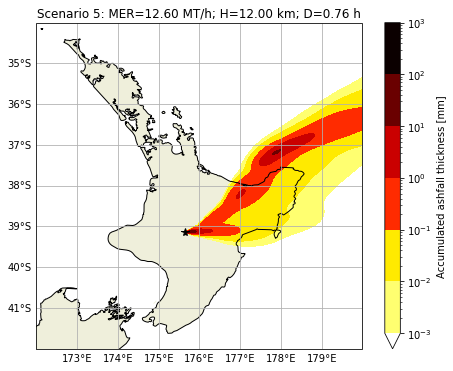

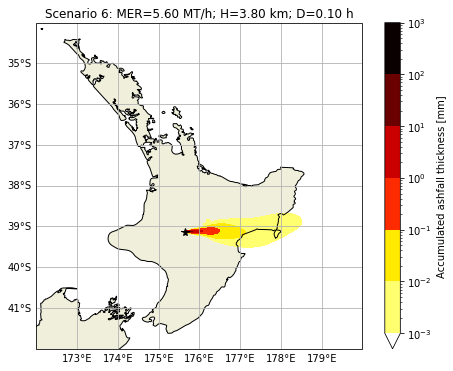

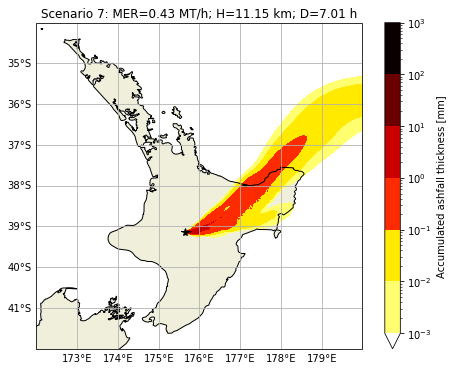

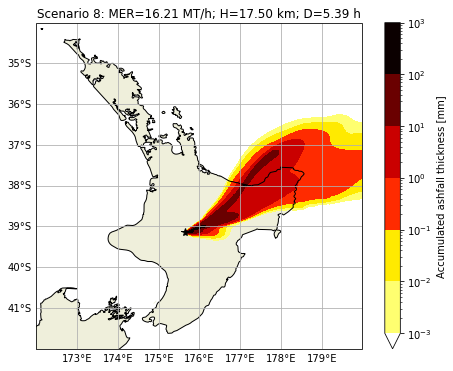

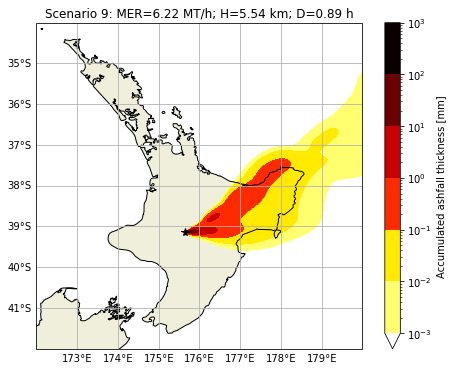

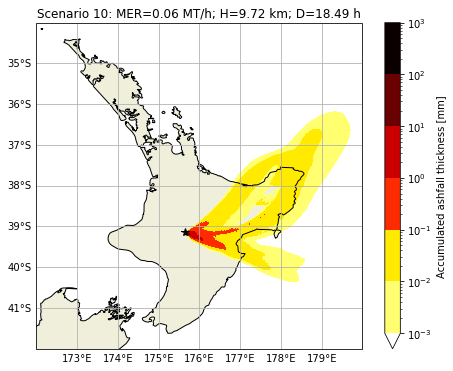

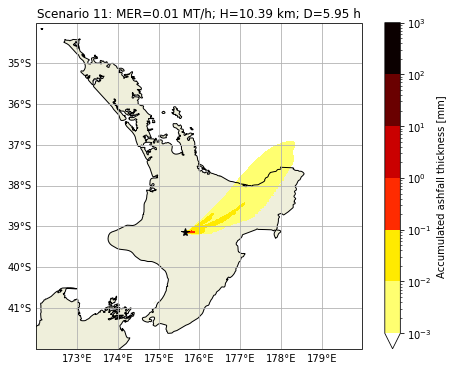

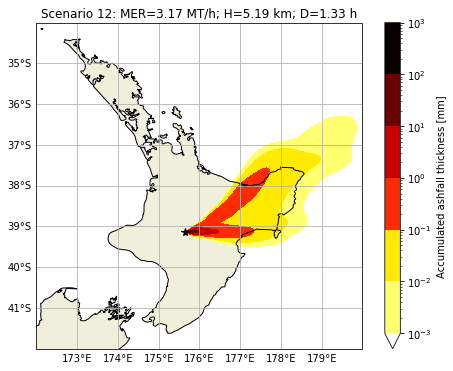

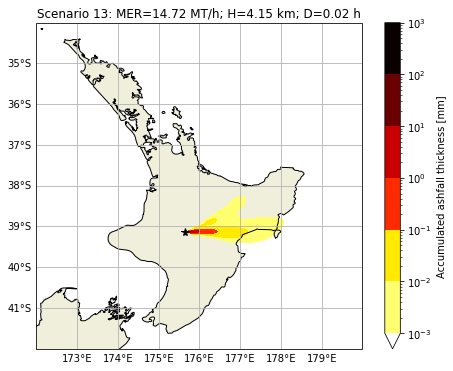

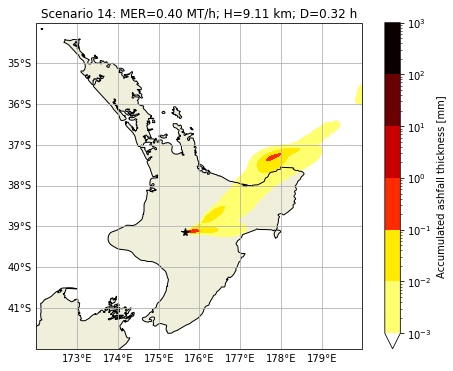

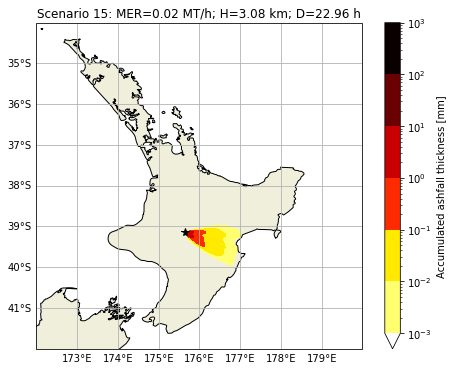

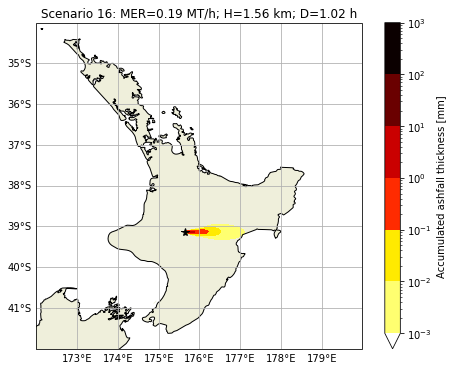

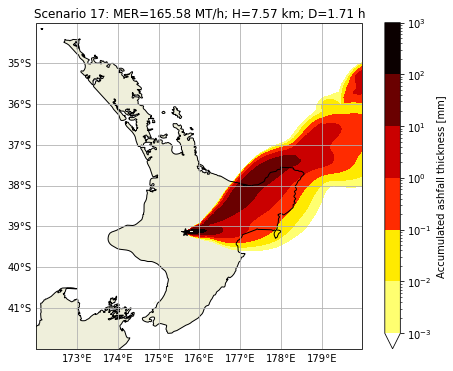

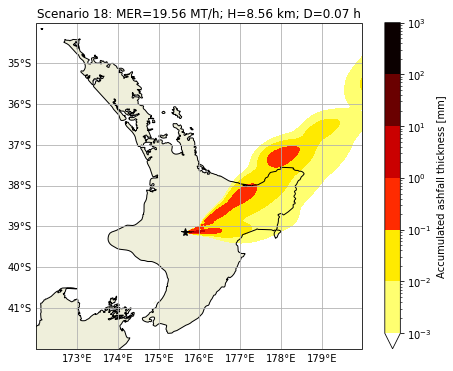

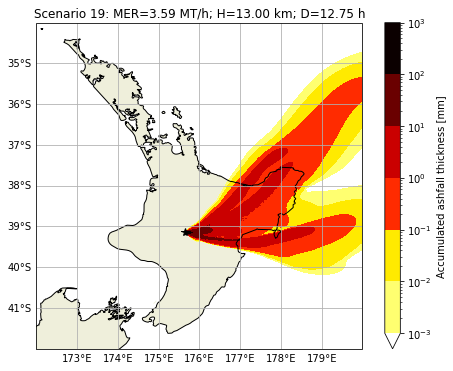

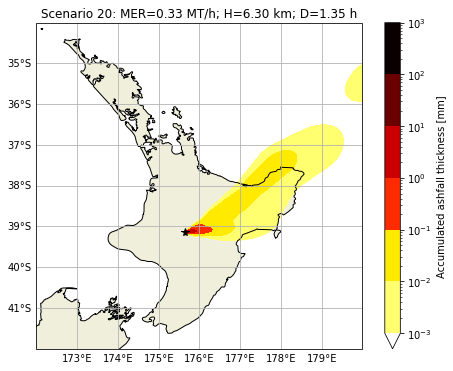

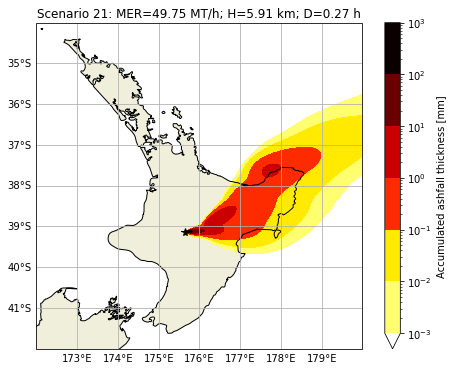

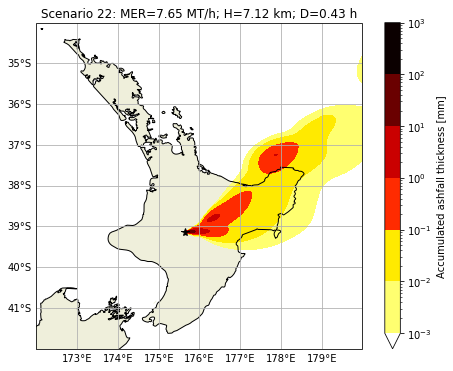

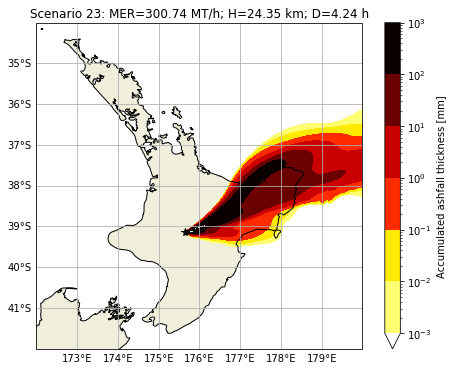

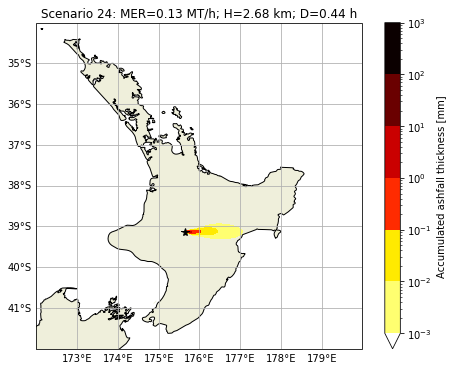

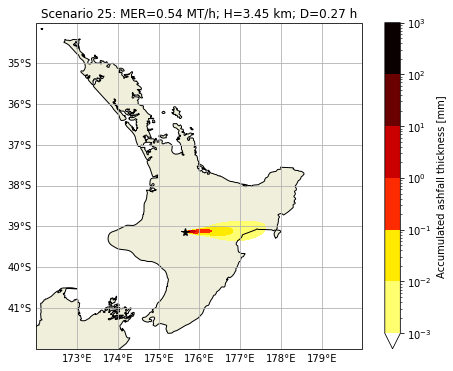

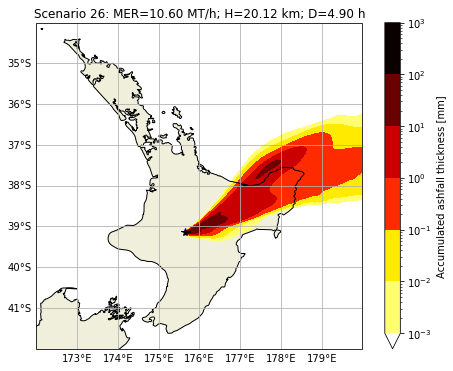

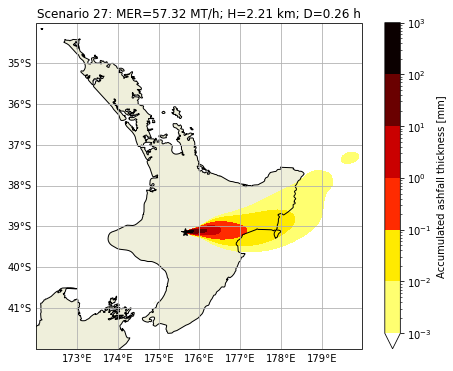

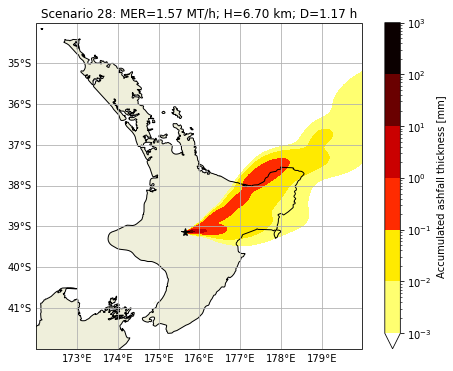

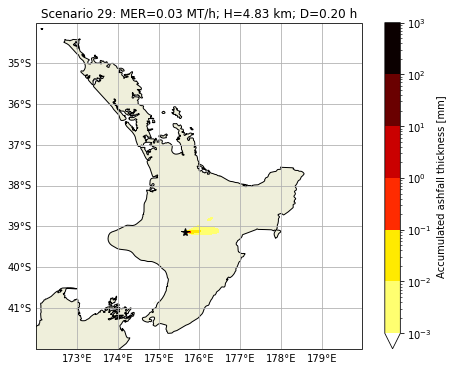

In [16]:
for idx in range(nidx):
    scenario = scenarios.iloc[idx]
    da = ds['total_deposition'].isel(idx=idx, time=it)
    
    fig, ax = plt.subplots(1,1, figsize=(8,6), subplot_kw={"projection": ccrs.PlateCarree(clon)})
    p1 = da.plot.contourf(ax=ax, levels=levs, cmap=cmap2, norm=LogNorm(vmin=levs[0], vmax=levs[-1]), 
        extend='min',
        transform=ccrs.PlateCarree(),
        cbar_kwargs={'label': 'Accumulated ashfall thickness [mm]'},
    )

    ax.plot(vlon,vlat, transform=ccrs.PlateCarree(), marker='*', ms=8, color='k')
    plot_decor(ax)
    txtstr = 'Scenario {}: MER={MER:.2f} MT/h; H={H:.2f} km; D={D:.2f} h'.format(idx, **scenario)
    ax.set_title(txtstr)
    
    fileplot = fileplot_prefix + '_ashfall_idx{:03d}.png'.format(idx)
    print(fileplot)
    fig.savefig(fileplot, **fig_args)
    #plt.close()
    